# Time Series Modeling

## Decompostion of time series
### Systematic components
* level
* trend
* seasonality

## Non-systematic component
* Noise

## Getting the data

In [28]:
%matplotlib widget

In [29]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
import quandl
from matplotlib import pyplot as plt

In [30]:
plt.rcParams['figure.figsize'] = [10, 5]

In [31]:
import seaborn as sns

In [32]:
sns.set()

In [33]:
pd.options.plotting.backend = 'matplotlib'

In [34]:
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD', 
           start_date='2000-01-01',
           end_date='2011-12-31')
df.rename(columns={'Value': 'price'}, inplace=True)
df = df.resample('M').last()

In [35]:
WINDOW_SIZE = 12
df['rolling_mean'] = df['price'].rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df['price'].rolling(window=WINDOW_SIZE).std()


<AxesSubplot:title={'center':'Gold price'}, xlabel='Date'>

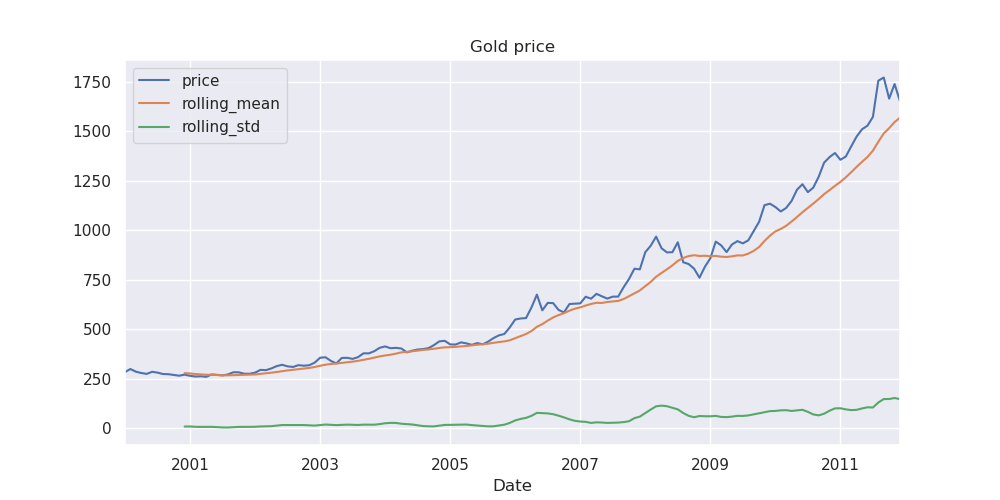

In [36]:
df.plot(title='Gold price')

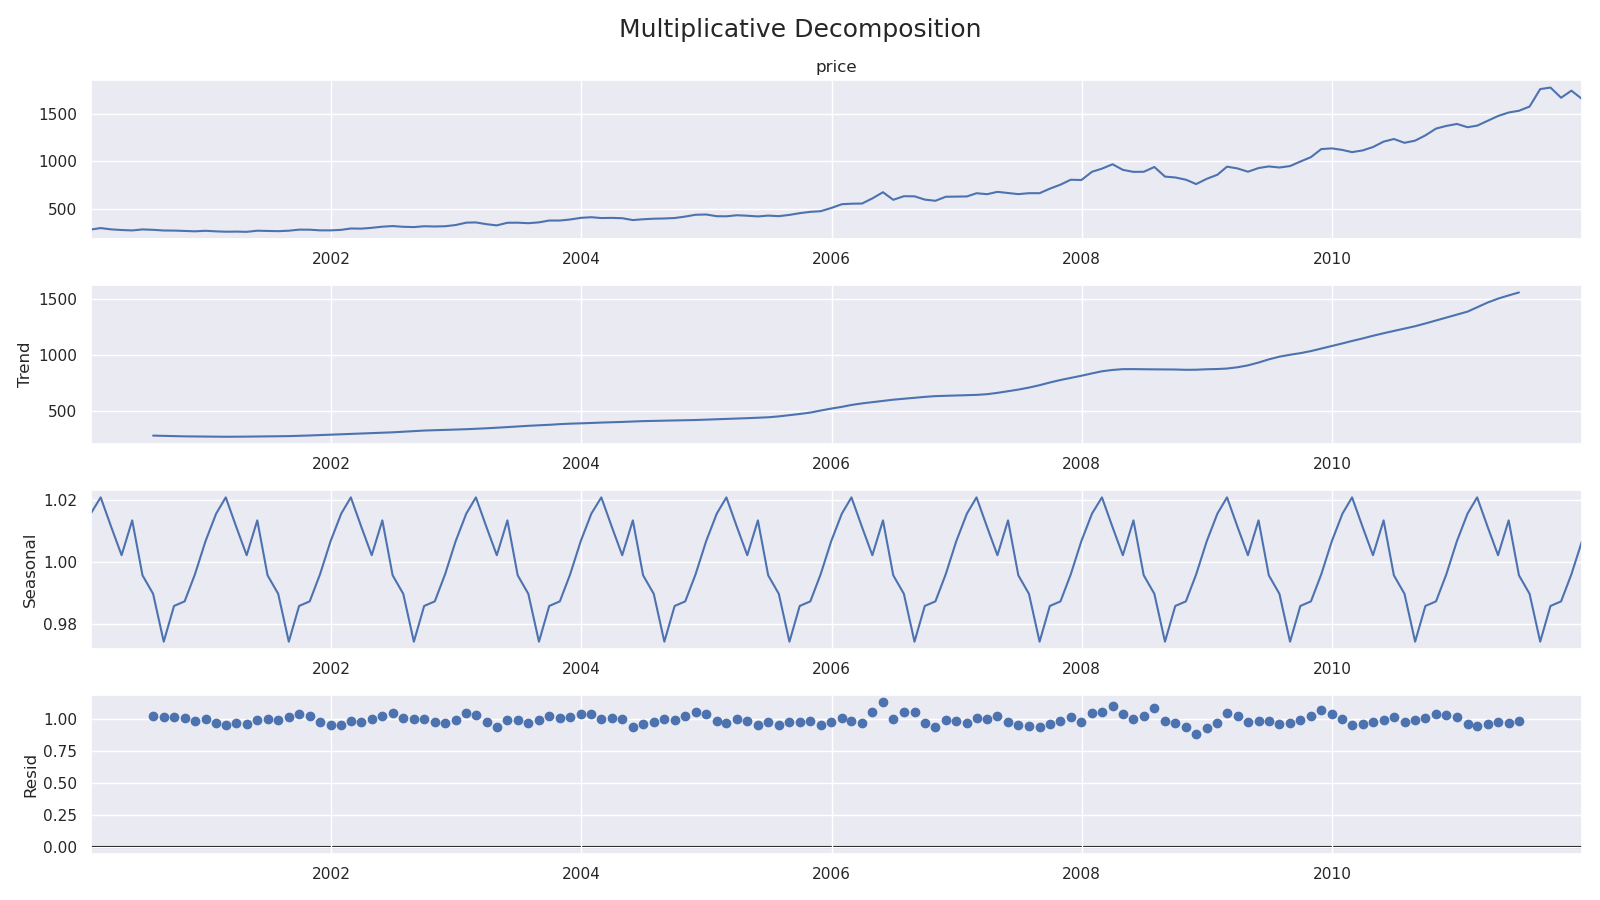

In [37]:

decomposition_results = seasonal_decompose(df['price'], model='multiplicative')
fig = decomposition_results.plot()
fig.suptitle('Multiplicative Decomposition', fontsize=18)
fig.set_size_inches((16,9))
fig.tight_layout()
plt.show()

## Exponential smoothing methods

## ARIMA

## Additive Model using Facebook's Prophet

In [38]:
df = quandl.get(dataset='WGC/GOLD_DAILY_USD',
                start_date='2000-01-01',
                end_date='2005-12-31')

df.reset_index(drop=False, inplace=True)
df.rename(columns={'Date': 'ds', 'Value': 'y'}, inplace=True)
df.head()

,ds,y
0,2000-01-03,290.25
1,2000-01-04,281.50
2,2000-01-05,280.45
3,2000-01-06,279.40
4,2000-01-07,282.10


In [39]:
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [40]:
train_indices = df['ds'].apply(lambda date: date.year) < 2005
df_train = df.loc[train_indices].dropna()
df_test = df.loc[~train_indices].reset_index(drop=True)

In [41]:
from fbprophet import Prophet

In [44]:
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.84269


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4332.99    0.00123209       432.082      0.6899      0.6899      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4367.86     0.0018642        963.65      0.1658           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4401.23    0.00361294       686.326      0.2911           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4461.92     0.0113232       3608.95       0.506       0.506      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4488.67     0.0027555        1161.5           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599     

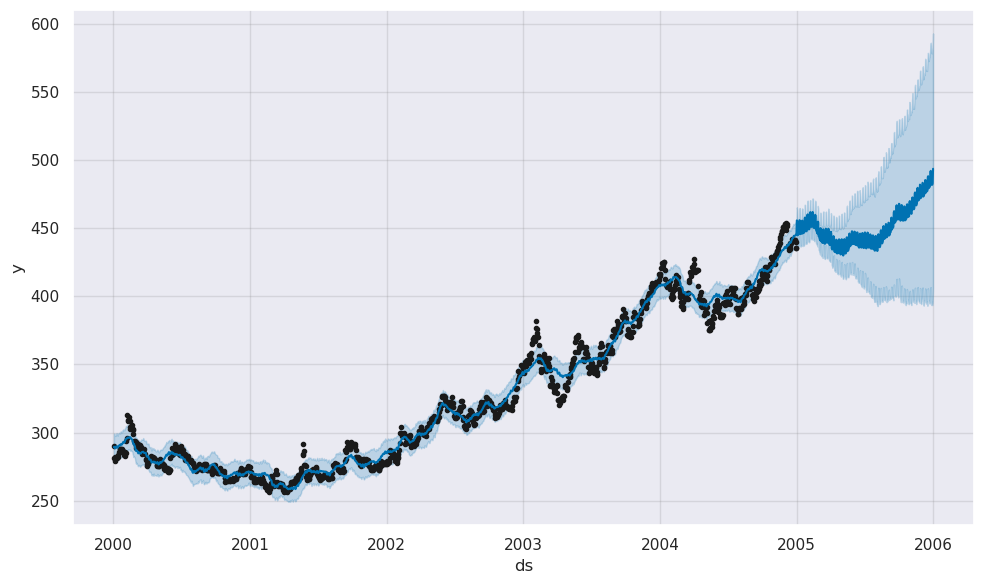

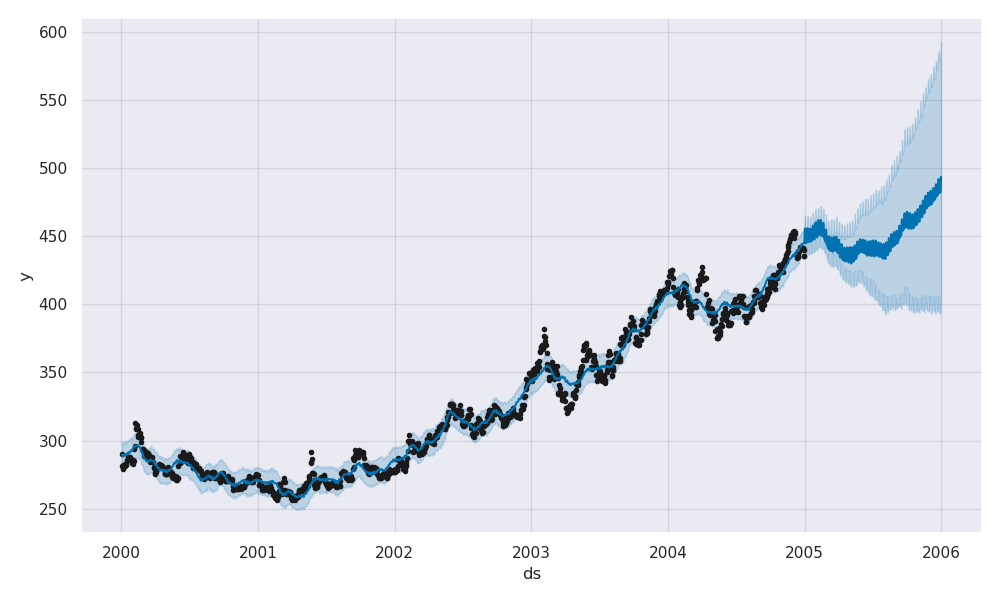

In [45]:
df_feature = model_prophet.make_future_dataframe(periods=365)
df_pred = model_prophet.predict(df_feature)
model_prophet.plot(df_pred)

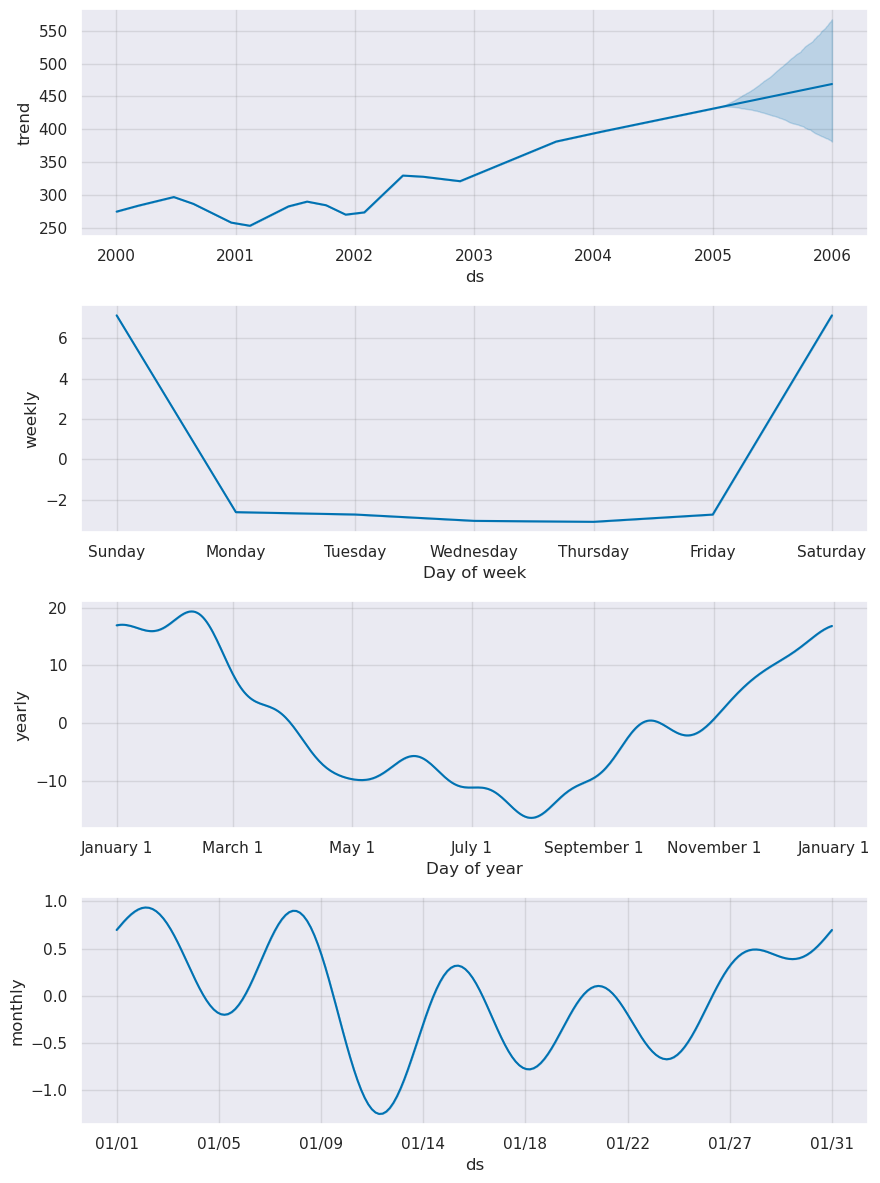

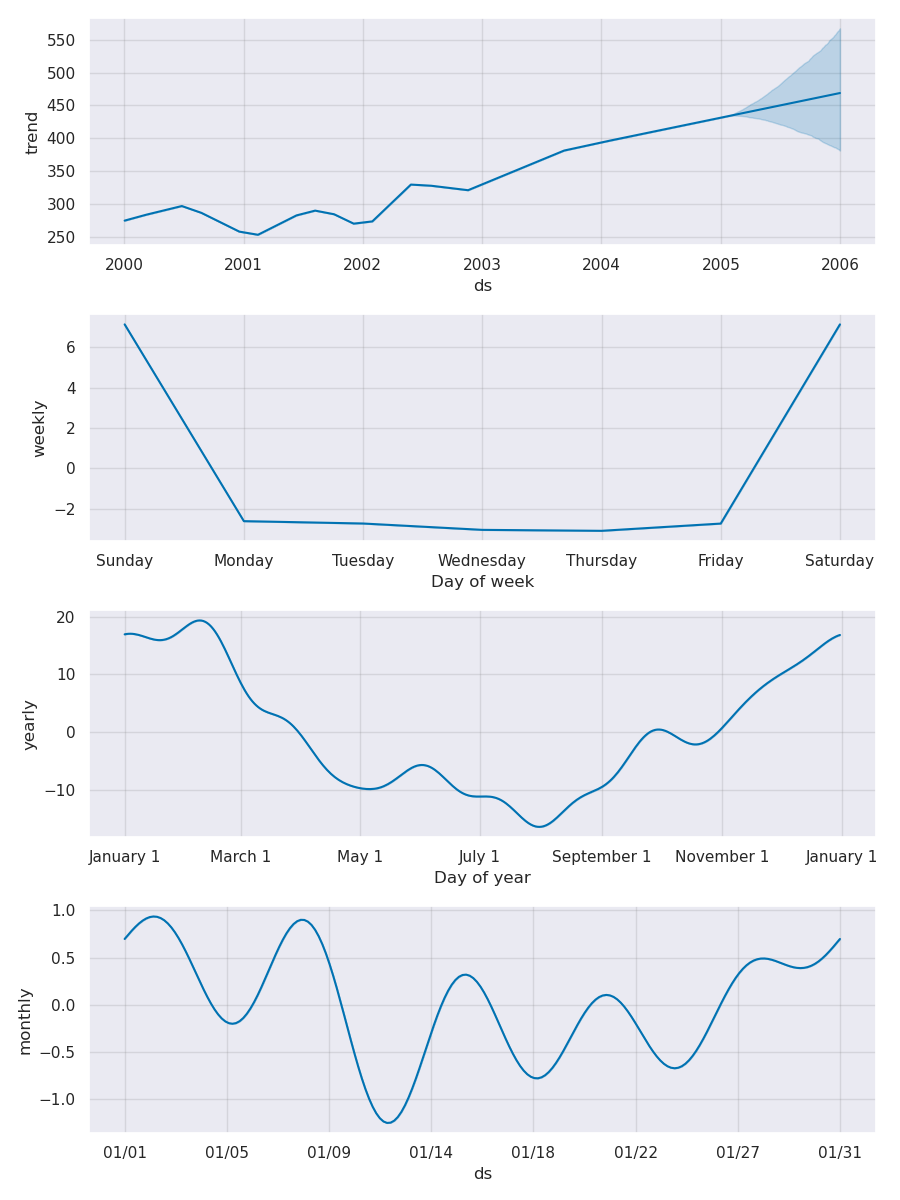

In [47]:
model_prophet.plot_components(df_pred)

## Evaluation
Information about basic performance of fitted model

In [48]:
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)

In [49]:
df_pred.head()

,ds,yhat_lower,yhat_upper,yhat
0,2000-01-03,280.056974,298.925670,289.408987
1,2000-01-04,280.475137,299.313881,289.474851
2,2000-01-05,279.312878,297.947973,288.826839
3,2000-01-06,278.792873,297.888285,288.422448
4,2000-01-07,279.870238,297.428277,288.835076


In [51]:
df_merged = df_test.merge(df_pred, on=['ds'], how='left')
df_merged['ds'] = pd.to_datetime(df_merged['ds'])
df_merged.set_index('ds', inplace=True)

[Text(0.5, 1.0, 'Gold Price - actual vs. predicted'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Gold Price ($)')]

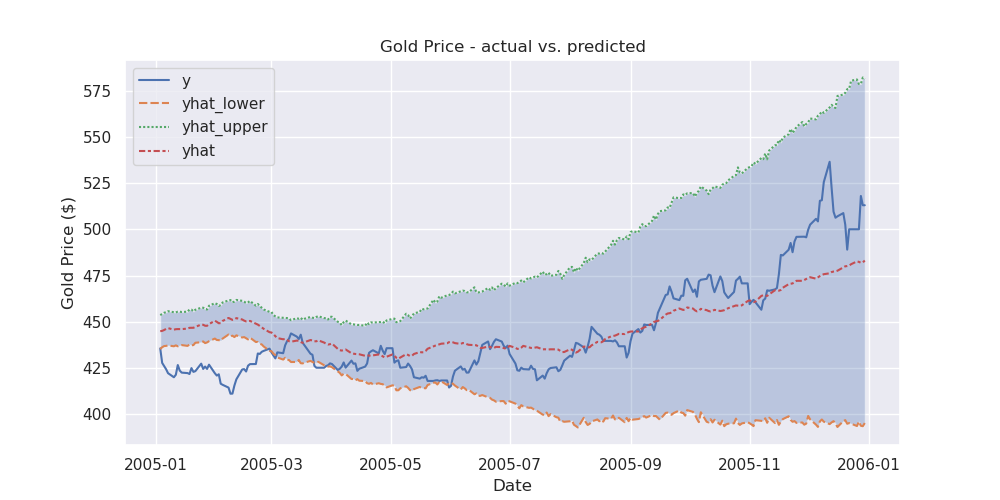

In [52]:
fig, ax = plt.subplots(1,1)
plot_columns = ['y', 'yhat_lower', 'yhat_upper', 'yhat']
ax = sns.lineplot(data=df_merged[plot_columns])
ax.fill_between(df_merged.index, df_merged['yhat_lower'], df_merged['yhat_upper'], alpha=0.3)
ax.set(title='Gold Price - actual vs. predicted', xlabel='Date', ylabel='Gold Price ($)')